In [4]:
import numpy as np
from fluid import Fluid
import scipy as sp
from scipy import optimize as op
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import json

In [32]:
pipe_dP = 0
pipe_dT = 0

initial_temperature = 0
initial_pressure = 0

# pull from pipe-draft script

%store -r pipe_dP
%store -r pipe_dT

%store -r initial_temperature
%store -r initial_pressure

print(initial_pressure)
print(initial_temperature)

20566065.931159586
313.49545467421115


In [29]:
def netPow(x):
    try:
        m_dot_c, P_pump_discharge = x

        #Givens
        m_dot_s = 3.2 # mass flow of the continuous supply being sequestered (s for sequestration)
        #State 5 is the incoming sequestration state 
        T5 = initial_temperature # 273.15 + 10 #assuming this is the state going into sequestration (at the beginning of pipe)
        P5 = initial_pressure

        #State 1
        m_dot_1 = m_dot_s + m_dot_c
        T1 = T5 # to match sequestration state
        P1 = P5 #to match sequestration state

        co2 = Fluid('co2')
        s1 = co2.entropy(T=T1, P=P1)
        h1 = co2.enthalpy(T = T1, P = P1)

        #State 2
        m_dot_2 = m_dot_s + m_dot_c
        s2 = s1 #Pump modeled as isentropic
        P2 = P_pump_discharge #Free variable

        h2 = co2.enthalpy(S = s2, P = P2)
        T2 = co2.temperature(S = s2, P = P2)

        pow_in = m_dot_2 * (h2 - h1)

        #State 3
        dP=pipe_dP #for now
        dT=pipe_dT #for now
        m_dot_3 = m_dot_c
        P3 = P2 + dP #dP is the pressure loss of the underground system
        T3 = T2 + dT #dT is the temperature increase after the underground system

        s3 = co2.entropy(T=T3, P=P3)
        h3 = co2.enthalpy(T = T3, P = P3)

        #State 4
        m_dot_4 = m_dot_c
        s4 = s3 #Turbine modeled as isentropic
        P4 = P1 # Condenser modeled as isobarric

        h4 = co2.enthalpy(S = s4, P = P4)
        pow_out = m_dot_4 * (h3 - h4)
        
        net_pow = (pow_out - pow_in)
        return net_pow
    except Exception as e:
        print(f"caught {e}")
        return 1e-12

#t = op.minimize_scalar(net_pow, [param_dict['T_inf'], T_l_init, 275], bounds=(0, np.inf))

119852335.88132572


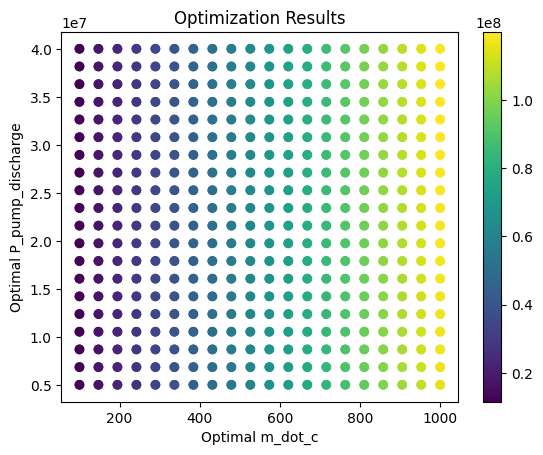

In [45]:
# Initial guess for the optimization
cost = lambda x: 1 / netPow(x)**2
# Call minimize function


# find the optimal power at each

# Define the range of initial conditions
mdot_range = np.linspace(100, 1000, 20)
pump_range = np.linspace(5e6, 40e6, 20)

# Initialize lists to store the optimal values and minimum net power
optimal_m_dot_c_list = []
optimal_P_pump_discharge_list = []
minimum_net_pow_list = []

# Iterate over each set of initial conditions
for mdot in mdot_range:
    for pump in pump_range:
        initial_guess = [mdot, pump]
        
        # Perform optimization
        result = op.minimize(cost, initial_guess, bounds=[(0, 1000), (0, 100e6)])
        
        # Extract the optimal values
        optimal_m_dot_c, optimal_P_pump_discharge = result.x
        optimal_m_dot_c_list.append(optimal_m_dot_c)
        optimal_P_pump_discharge_list.append(optimal_P_pump_discharge)
        
        # Calculate the minimum net power
        minimum_net_pow = netPow(result.x)
        minimum_net_pow_list.append(minimum_net_pow)

print(minimum_net_pow)
# Plot the results
fig, ax = plt.subplots()
ax.scatter(optimal_m_dot_c_list, optimal_P_pump_discharge_list, c=minimum_net_pow_list, cmap='viridis')
ax.set_xlabel('Optimal m_dot_c')
ax.set_ylabel('Optimal P_pump_discharge')
ax.set_title('Optimization Results')
plt.colorbar(ax.scatter(optimal_m_dot_c_list, optimal_P_pump_discharge_list, c=minimum_net_pow_list, cmap='viridis'))
plt.show()



In [41]:
cost = lambda x: 1/netPow(x)
initial_guess = [10,4e7]
print(f"{netPow(initial_guess)} from initial conditions")
result = op.minimize(cost, initial_guess,
                     bounds=[(0,15),(600000,np.Inf)], # not sure if this is OK, set minimum bound to 6 MPa 
                     method='Nelder-Mead')
 
# Extract the optimal values
optimal_P_pump_discharge = result.x
print(optimal_P_pump_discharge)
# You can also get the minimum value of netPow
minimum_net_pow = netPow(result.x)

print(minimum_net_pow)


1128033.5864140498 from initial conditions
[1.5e+01 6.0e+05]
2003899.4489535936
